# Chap 03. Classification

---
## 3.1 MNIST

#### 3.1.1 MNIST 데이터셋 다운로드 받기

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False) ## 기본적으로 pandas dataframe인 데이터셋을 numpy로 받음

In [3]:
X, y = mnist.data, mnist.target

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음을 확인한다.

이는 이미지가 28x28 픽셀이기 때문이다.

각각의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

#### 3.1.2 이미지 확인하기

<function matplotlib.pyplot.show(close=None, block=None)>

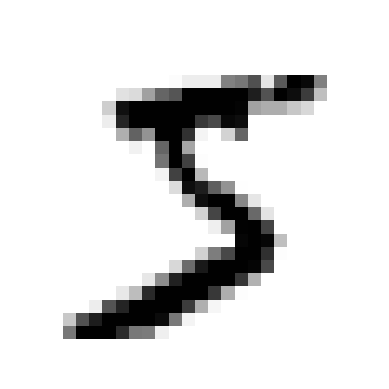

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data) :
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary") # 흑백 컬러맵 사용
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show

#### 3.1.3 훈련, 테스트셋 나누기

fetch_openml의 MNIST 데이터셋은 이미 훈련세트와 테스스 세트가 나뉘어져 있다.

그래서 해당 이미지 세트에 맞게 세트를 분리해준다.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000], y[:60000], y[60000]

---

## 3.2 Binary Classifier (이진 분류기)

#### 3.2.1 5감지기 모델 생성하기

'5'와 '5가 아님' 두가지 클래스를 구분할 수 있는 이진 분류기를 생성해본다.

In [6]:
y_train_5 = (y_train == '5') ## 5는 True, 나머지는 False
y_test_5 = (y_test == '5')

이제 분류 모델 **Stochastic Gradient Descent** (SGD, 확률적 경사 하강법) 분류기로 훈련시켜본다.

SGD는 한 번에 하나씩 훈련 샘플을 독립적으로 처리할 수 있다.

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

이전에 some_digit을 X[0]즉 숫자 5 이미지로 설정하였다.

해당 이미지에 대해 True라고 추측하였으므로 기대한 결과를 얻을 수 있었다.

---
## 3.3 Model Performance Assessment (성능 측정)

#### 3.3.1 교차 검증을 사용한 정확도 측정


**k-fold 교차 검증**을 위해 데이터가 클래스별 비율이 유지되도록 폴드를 생성한다.

매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다.

그 다음 올바른 예측 수를 세어 정확한 예측 비율을 출력한다.

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [11]:
cross_val_score(dummy_clf, X_train, y_train_5,cv =3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

아무것도 학습하지 않은 dummy 분류기가 모든 데이터를 '5가 아님'이라고 예측 했음에도

정확도가 90%이상이 나옴을 확인할 수 있다.

분류기의 성능 측정 지표로 정확도를 선호하지 않는 이유이다.

#### 3.3.2 Confusion Matrix (오차 행렬)

**오차 행렬**이란 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.

특정 클래스가 분류된 횟수를 보고 싶으면, 해당 행을 보면 된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다.

Cross Validation을 이용하여 학습에 포함되지 않은 out-of-sample에 대해서도

예측할 수 있도록 한다.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

위의 결과값을 분석하면, 53,892개를 '5 아님'으로 정확하게 분류했고 687개를 '5'라고 잘못 분류했다.

두 번째 행은 '5'이미지에 대한 것으로, 1,891개를 '5 아님'으로 잘못 분류했고

3,530개를 정확히 '5'라고 분류했다.

추가적으로, Confusuion Matrix는 클래스의 라벨을 오름차순으로 정렬하기 때문에

| - | 0 | 1 |
|:----------:|:----------:|:----------:|
| 0 | 53892  | 687  |
| 1 | 1891  | 3530  |

이런 형태가 된다.

#### 3.3.3 Precision& Recall (정밀도와 재현율)

더 요약된 지표인 정밀도의 식 :

$ \text{Precision} = \frac{TP}{TP + FP} $

TP는 True Positive, FP는  False Positive

정밀도와 같이 사용하는 재현율의 식 :

$ \text{Recall} = \frac{TP}{TP + FN} $

이제 사이킷런이 제공하는 함수를 이용하여 5-분류기에 대한 정밀도와 재현율을 얻어보자


In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

이제 정밀도와 재현율을 F1 score라고 하는 하나의 숫자로 만들자.

F1 score는 정밀도와 재현율의 **조화 평균**이다.

마찬가지로 관련 함수를 호출하면 된다.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높다

하지만 이게 항상 바람직한 것은 아니다.

예를 들어 암 발병여부와 같은 경우, 재현율이 중요하고

금융사기 탐지같은 경우 정밀도가 더 중요하다.

하지만 정밀도와 재현율을 둘다 얻을 수는 없다. 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지.

#### 3.3.4 Trade-Off (Precision & Recall)

최적의 정밀도, 재현율을 구하기 위해선 **decision threshold**에 대해 알아야 한다.

이 결정 임계값은 그 기준으로 하여금 양성과 음성 판단을 결정한다.

사이킷 런에서는 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [19]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

threshold를 각각 0, 3000으로 했을 때 결과가 다름을 확인할 수 있다.

그렇다면 어떻게 적절한 임계값을 설정할 수 있을까?

먼저 cross_val_predict()함수를 이용하여 train 세트의 모든 샘플 점수를 구해야한다.

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3, method = "decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve ##가능한 모든 임계값에 대해 정밀도와 재현율을 계산한다.

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

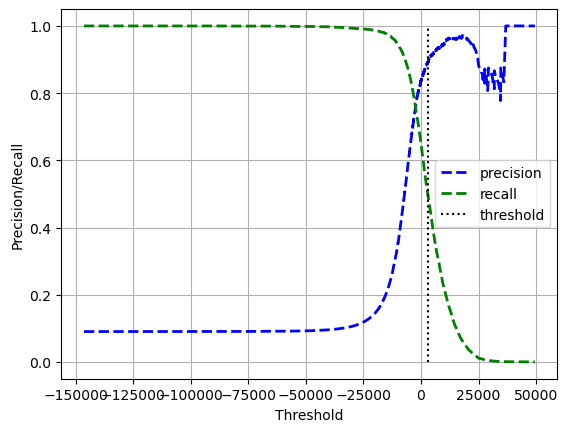

In [27]:
plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

plt.grid(True)
plt.legend(loc="best")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.show()

이제 트레이드 오프를 정하기 위해서 정밀도/재현율 그래프를 그린다

Text(0.5, 0.95, 'High precision point')

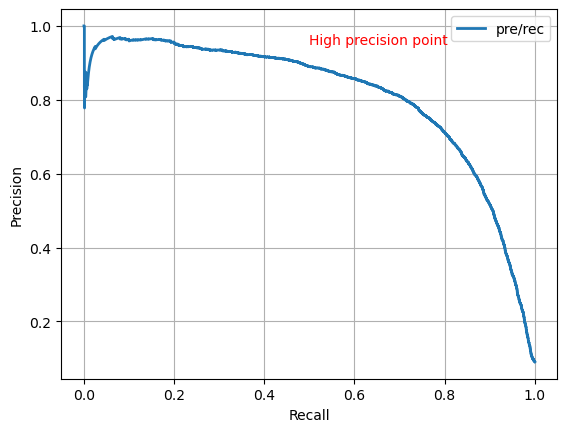

In [30]:
plt.plot(recalls, precisions, linewidth = 2, label = "pre/rec")

plt.grid(True)

plt.legend(loc="best")

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.annotate(
    "High precision point",
    xy=(0.8, 0.9),            
    xytext=(0.5, 0.95),       
    
    fontsize=10,
    color="red"
)

재현율 80%근처에서 정밀도가 급하게 줄어든다.

이 하강점 직전을 트레이드오프로 선택하는것이 좋다.

예를 들어 재현율 60% 지점이다.